##  https://www.kaggle.com/code/calven22/forecasting-inflation-with-arima-and-lstm

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

np.random.seed(234)
tf.random.set_seed(234)

2024-04-22 17:06:49.168784: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 17:06:49.223450: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 17:06:54.527411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.__version__)

2.16.1


In [3]:
data = pd.read_csv('InflationData.csv')

In [4]:
data = data.set_index('DATE')
data.head()

,OIL,PersonalExpenditure,RealDisposableIncome,M2REAL,Unemployment,InterestRate,FoodIndex
DATE,,,,,,,
1/1/59,13.9,306.1,2318.4,987.9,6.0,2.48,29.8
2/1/59,13.9,309.6,2325.4,992.1,5.9,2.43,29.7
3/1/59,14.0,312.7,2338.7,998.3,5.6,2.80,29.5
4/1/59,14.0,312.2,2353.8,1001.0,5.2,2.96,29.5
5/1/59,14.0,316.1,2366.6,1006.2,5.1,2.90,29.5


## Forecasting Inflation

<Axes: xlabel='DATE'>

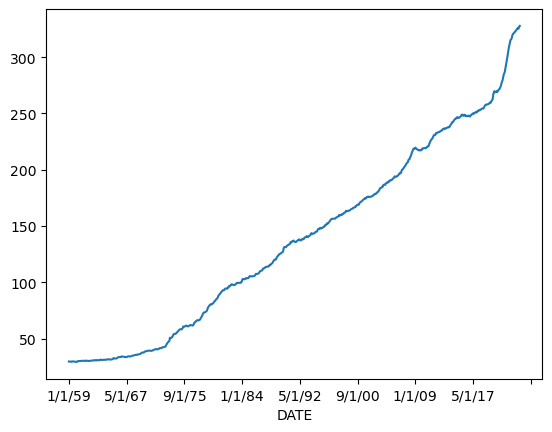

In [5]:
data['FoodIndex'].plot()


In [6]:

#long term split train (1959, 2010) and test (2011, 2024)
#short term split train (1959, 2022) and test (2023,2024)
train_start_date = '1/1/59'
train_end_date = '11/1/22'
test_start_date = '1/1/23'
test_end_date = '1/1/24'

train = data.loc[train_start_date:train_end_date]
test = data.loc[test_start_date:test_end_date]

print('Training dataset: %d, Test dataset: %d' % (len(train), len(test)))
train.head()


Training dataset: 767, Test dataset: 13


,OIL,PersonalExpenditure,RealDisposableIncome,M2REAL,Unemployment,InterestRate,FoodIndex
DATE,,,,,,,
1/1/59,13.9,306.1,2318.4,987.9,6.0,2.48,29.8
2/1/59,13.9,309.6,2325.4,992.1,5.9,2.43,29.7
3/1/59,14.0,312.7,2338.7,998.3,5.6,2.80,29.5
4/1/59,14.0,312.2,2353.8,1001.0,5.2,2.96,29.5
5/1/59,14.0,316.1,2366.6,1006.2,5.1,2.90,29.5


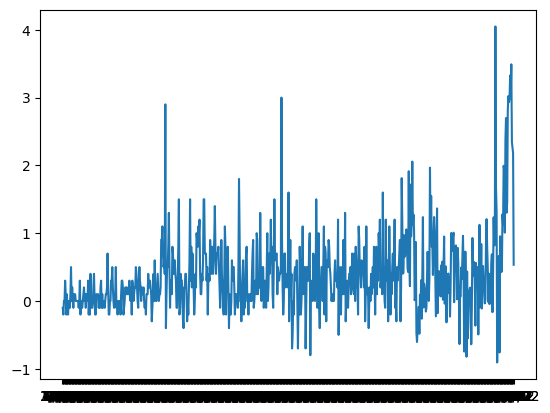

In [7]:
diff = train['FoodIndex'].diff()
plt.plot(diff)
plt.show()
diff = diff.dropna()

### Plot ACF and PACF
Now, we need to find the optimal p and q using acf and pacf plot. Where p is the number of lags and q is the order of the MA term. <br><br>
Finding the order of Auto Regressive Term (p)
- PACF lag 1 is significant

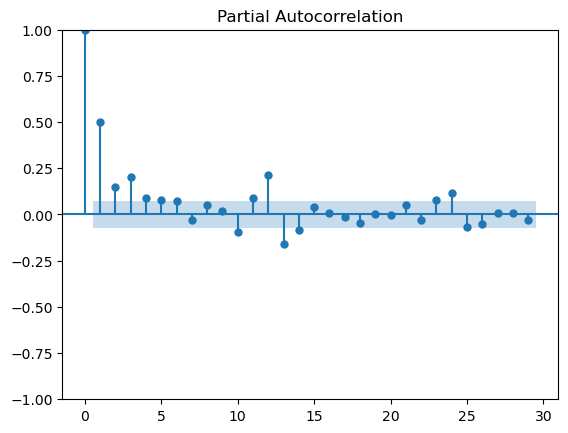

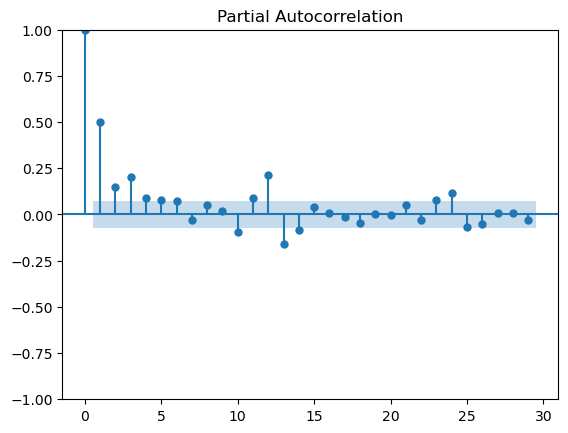

In [8]:
plot_pacf(diff.values)

Finding the order of Moving Average Term (q)<br>
- q = 1 and 2 is significant, try conservative take of q = 1.

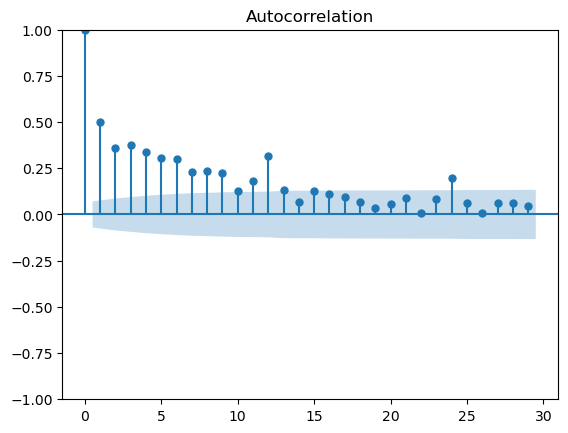

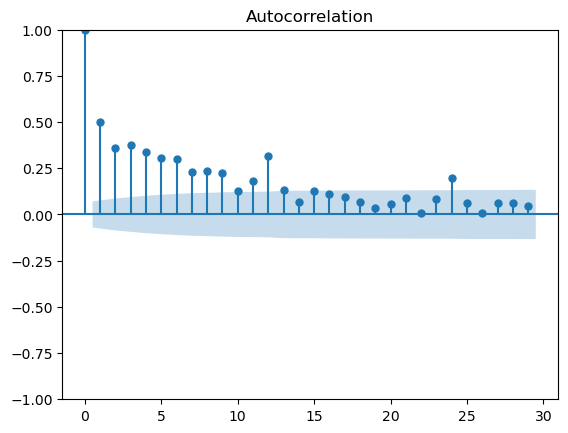

In [9]:
plot_acf(diff.values)

In [10]:
data = data.reset_index()

train = train.reset_index()
test = test.reset_index()

In [11]:
train = train["FoodIndex"]
test = test["FoodIndex"]
train.head()

0    29.8
1    29.7
2    29.5
3    29.5
4    29.5
Name: FoodIndex, dtype: float64

In [12]:
prev = data.loc[700:]
prev = prev['FoodIndex']
prev

700    250.016
701    249.653
702    250.214
703    250.493
704    250.993
        ...   
777    325.731
778    325.172
779    325.409
780    327.327
781    327.731
Name: FoodIndex, Length: 82, dtype: float64

In [13]:
arima_model = ARIMA(train, order = (1,1,1))
arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              FoodIndex   No. Observations:                  767
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -530.366
Date:                Mon, 22 Apr 2024   AIC                           1066.733
Time:                        17:07:11   BIC                           1080.656
Sample:                             0   HQIC                          1072.093
                                - 767                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9838      0.008    126.397      0.000       0.969       0.999
ma.L1         -0.7610      0.025    -30.370      0.000      -0.810      -0.712
sigma2         0.2334      0.006     39.055      0.000       0.222       0.245
===================================================================================
Ljung-Box (L1) (Q):                   8.34   Jarque-Bera (JB):              1209.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.10   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

767    317.788943
768    319.689627
769    321.559557
770    323.399232
771    325.209140
772    326.989763
773    328.741576
774    330.465044
775    332.160625
776    333.828772
777    335.469928
778    337.084530
779    338.673007
Name: predicted_mean, dtype: float64


Text(0.5, 1.0, 'ARIMA Prediction')

Text(0.5, 0, 'Dates')

Text(0, 0.5, 'Food Index')

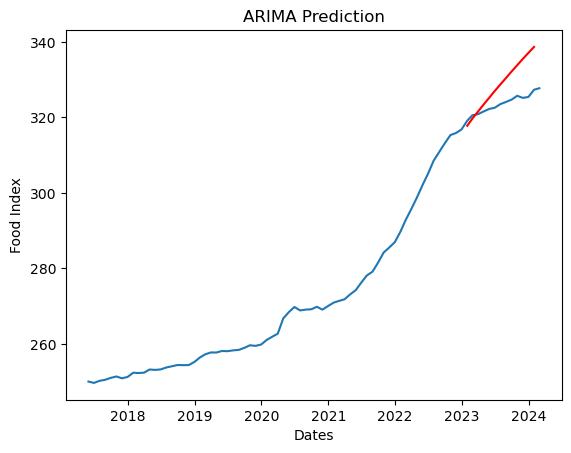

In [14]:
s = len(prev)
forecast = arima_fit.forecast(steps=len(test))
#forecast = np.exp(forecast)
print(forecast)
#forecast = np.exp(forecast)
dates = pd.date_range('5/1/2017', periods=s, freq='m')
date = pd.date_range(test_start_date, periods=len(test), freq='m')
plt.plot(dates, prev)
plt.plot(date, forecast, color = 'red')
#plt.plot(dates, test["FoodIndex"], color = 'blue')
plt.title("ARIMA Prediction")
plt.xlabel("Dates")
plt.ylabel("Food Index")
#plt.xticks(np.arange(2017,2024, 1))
#plt.xticks(ticks=train[700:].index, labels = dates, rotation='vertical')

#plt.xticks(ticks=test.index, labels=dates, rotation='vertical')

In [15]:
test.tail()

8     324.704
9     325.731
10    325.172
11    325.409
12    327.327
Name: FoodIndex, dtype: float64

Text(0.5, 1.0, 'True vs Predicted Food Inflation')

Text(0.5, 0, 'Dates')

Text(0, 0.5, 'Food Index')

(array([19417., 19478., 19539., 19601., 19662., 19723.]),
 [Text(19417.0, 0, '2023-03'),
  Text(19478.0, 0, '2023-05'),
  Text(19539.0, 0, '2023-07'),
  Text(19601.0, 0, '2023-09'),
  Text(19662.0, 0, '2023-11'),
  Text(19723.0, 0, '2024-01')])

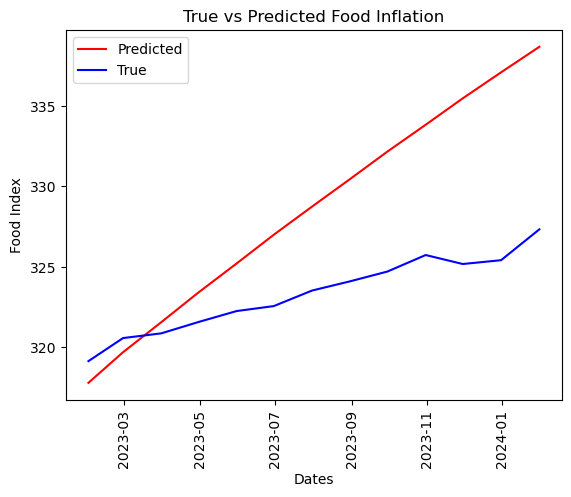

In [16]:
dates = pd.date_range(test_start_date, periods=len(test), freq='m')
plt.plot(dates, forecast, color = 'red', label="Predicted")
plt.plot(dates, test, color = 'blue', label ="True")
plt.title("True vs Predicted Food Inflation")
plt.xlabel("Dates")
plt.ylabel("Food Index")
plt.xticks(rotation='vertical')
plt.legend()

In [32]:

mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print('RMSE: ', rmse)
model_error = np.array(test) - np.array(forecast)

print('Mean Model Error: ', model_error.mean())

RMSE:  6.764580522526904
Mean Model Error:  -5.242672601164888
